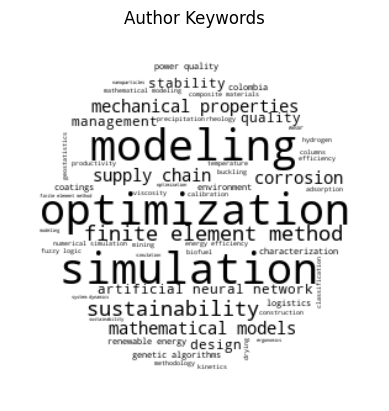

In [3]:
import os, sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
# --- 
from techminer2 import vantagepoint
from matplotlib import pyplot as plt

vantagepoint.report.word_cloud(
    criterion='author_keywords',
    title="Author Keywords",
    topics_length=50,
    directory="dyna/",
);
